In [167]:
import phoebe 
import torch 
from phoebe import u, c
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [168]:
lc = np.loadtxt('/Users/karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/detrended_lc.dat') 
rvs = np.loadtxt('/Users/karan/Documents/GitHub/Eclipsing-Binary-Modeling/data/rvs.dat') 

In [169]:
b = phoebe.default_binary()

In [170]:
lc_times = lc[:, 0] - 2400000
b.add_dataset('lc', times = lc_times,
               fluxes = lc[:, 3], 
               sigmas = lc[:, 4])

<ParameterSet: 80 parameters | contexts: figure, compute, constraint, dataset>

In [171]:
period = 10.3
b.set_value('period@binary', value = period)

ztime = 55750 # zero point within both c and rv ranges
b.set_value('t0_supconj', value = ztime)

teff1 = 6700 # avg temperature of F type main sequence star
b['teff@primary@component'] = teff1

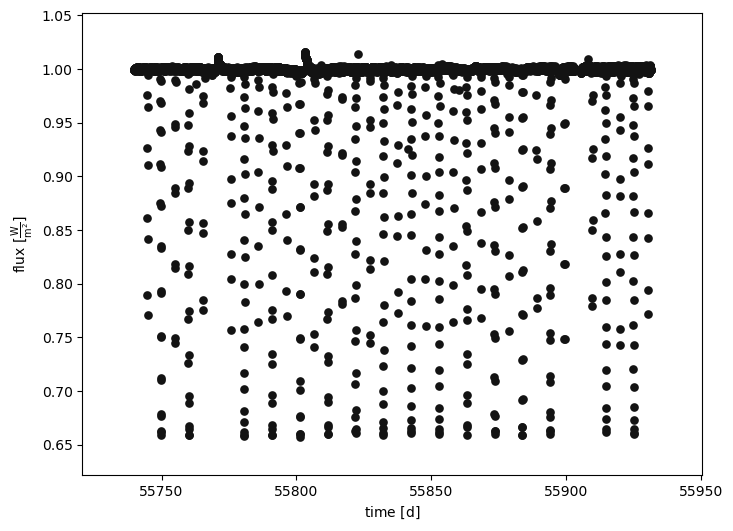

In [172]:
_ = b.plot(dataset = 'lc01', show = True, marker = '.')

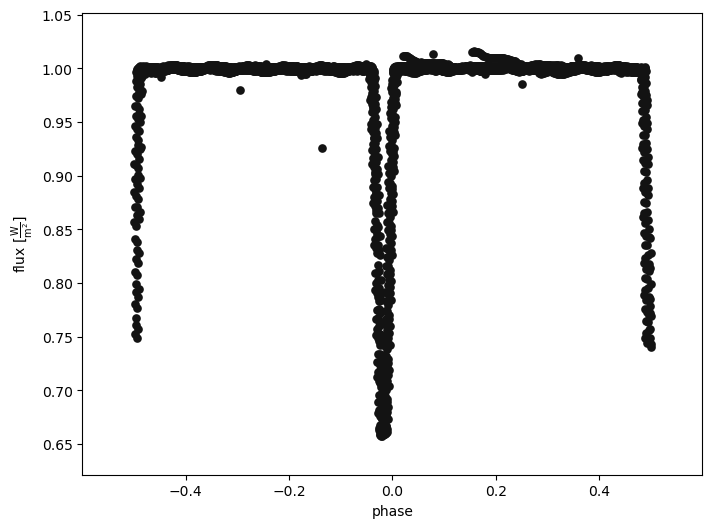

In [173]:
_ = b.plot(dataset = 'lc01', x = 'phases', show = True, marker = '.')

In [174]:
b.add_compute(compute = 'adam')

<ParameterSet: 39 parameters | datasets: lc01, _default>

In [175]:
b.set_value('pblum_mode', 'dataset-scaled')
b.set_value('irrad_method', compute = 'adam', value = 'horvat')
b.set_value_all('distortion_method', compute = 'adam', value = 'roche')

b.set_value_all('atm', value = 'blackbody')
b.set_value_all('ld_mode', 'manual')
b.set_value_all('ld_mode_bol', 'manual') 

In [176]:
b.flip_constraint('teffratio', solve_for = 'teff@secondary')
b.flip_constraint('requivratio', solve_for = 'requiv@primary')
b.flip_constraint('requivsumfrac', solve_for = 'requiv@secondary')

<ConstraintParameter: {requiv@secondary@component} = (({requivratio@binary@component} * {requivsumfrac@binary@component}) * {sma@binary@component}) / ({requivratio@binary@component} + 1.000000) (solar units) => 1.0 solRad>

In [177]:
def forward_model(b, params):

    teffratio, requivsumfrac, requivratio = [param.item() for param in params]

    b.set_value('teffratio@component', value = teffratio)
    b.set_value('requivsumfrac@component', value = requivsumfrac)
    b.set_value('requivratio@component', value = requivratio)

    b.run_compute(compute = 'adam', model = 'adam_lc')

    obs_fluxes = torch.tensor(b.get_value('fluxes@dataset'), dtype=torch.float32)
    obs_sigmas = torch.tensor(b.get_value('sigmas@dataset'), dtype=torch.float32)
    syn_fluxes = torch.tensor(b.get_value('fluxes@adam_lc'), dtype=torch.float32)

    return obs_fluxes, obs_sigmas, syn_fluxes

In [178]:
init_params = torch.tensor([0.5, 0.5, 0.5], dtype = torch.float32, requires_grad = True)

loss_fn = torch.nn.GaussianNLLLoss()
optimizer = torch.optim.Adam([init_params], lr = 0.001)

def train():

    optimizer.zero_grad()

    obs_fluxes, obs_sigmas, syn_fluxes = forward_model(b, init_params)    

    if len(obs_fluxes.shape) == 1:
        obs_fluxes = obs_fluxes.unsqueeze(0)
    if len(syn_fluxes.shape) == 1:
        syn_fluxes = syn_fluxes.unsqueeze(0)
    if len(obs_sigmas.shape) == 1:
        obs_sigmas = obs_sigmas.unsqueeze(0)

    loss = loss_fn(obs_fluxes, syn_fluxes, obs_sigmas)
    loss.backward()

    optimizer.step()

    return loss

In [179]:
epochs = 100

for epoch in range(epochs):
    loss = train()
    print(f'Epoch {epoch}, Loss: {loss.item()}, Params: {init_params.data.numpy()}')

100%|██████████| 8891/8891 [02:00<00:00, 73.73it/s] 


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn